# 2. Genetic Algorithm

Here, we show how to use DiCE can be used to generate CFs for any ML model by using the genetic algorithm to find the best counterfactuals close to the query point. The genetic algorithm converges quickly, and promotes diverse counterfactuals. 

In [2]:
from utils import helpers  # helper functions

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from model_interfaces import base_model
import data, dice
import model as dice_model

In [3]:
dataset = pd.read_csv('csv/adultdataset.csv')
dataset.head()

,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,28,Private,Bachelors,Single,White-Collar,White,Female,60,0
1,30,Self-Employed,Assoc,Married,Professional,White,Male,65,1
2,32,Private,Some-college,Married,White-Collar,White,Male,50,0
3,20,Private,Some-college,Single,Service,White,Female,35,0
4,41,Self-Employed,Some-college,Married,White-Collar,White,Male,50,0


In [4]:
target = dataset["income"]
# Split data into train and test
datasetX = dataset.drop("income", axis=1)
x_train, x_test, y_train, y_test = train_test_split(datasetX,
                                                    target,
                                                    test_size=0.2,
                                                    random_state=0,
                                                    stratify=target)

numerical = ["age", "hours_per_week"]
categorical = x_train.columns.difference(numerical)

# We create the preprocessing pipelines for both numeric and categorical data.
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

transformations = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical),
        ('cat', categorical_transformer, categorical)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', transformations),
                      ('regressor', LGBMRegressor())])
model = clf.fit(x_train, y_train)

In [5]:
np.random.choice(["a", "b", "c", "d"], p=[0.15, 0.35, 0.2, 0.3])

'b'

findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


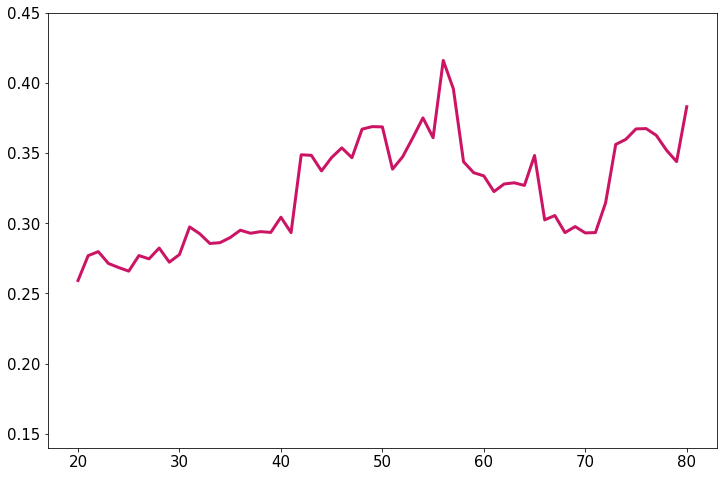

In [11]:
pred_list = []
for hw in range(20,81):
    temp = []
    for j in range(1000):
        # セグメント 2
        workclass = np.random.choice(['Government','Other/Unknown','Private','Self-Employed'], p=[0.13, 0.07, 0.68, 0.12])
        education = np.random.choice(['Assoc', 'Bachelors', 'Doctorate', 'Masters', 'School', 'Prof-school', 'HS-grad', 'Some-college'], p=[0.1, 0.11, 0.13, 0.11, 0.0, 0.12, 0.34, 0.09])
        marital_status = np.random.choice(['Separated', 'Divorced', 'Married', 'Widowed', 'Single'], p=[0.0050, 0.012, 0.94, 0.023, 0.020])
        occupation = np.random.choice(['Other/Unknown', 'Professional', 'Sales', 'Service', 'White-Collar', 'Blue-Collar'], p=[0, 0.23, 0.045, 0.049, 0.066, 0.61])
        race = np.random.choice(['Other', 'White'], p=[0.1033, 0.8967])
        gender = np.random.choice(['Female', 'Male'], p=[0.9131, 0.0869])

        test_instance = pd.DataFrame.from_dict({'age': 29,
                        'workclass': workclass,
                        'education': education,
                        'marital_status': marital_status,
                        'occupation': occupation,
                        'race': race,
                        'gender': gender,
                        'hours_per_week': hw}, orient='index').T

        temp.append(model.predict(test_instance)[0])
    pred_list.append(np.mean(temp))

plt.figure(figsize=(12,8))
plt.plot(range(20,81), pred_list, linewidth=3, color="#CC1464")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.xlabel("hours_per_week")
#plt.ylabel("High income probability")
plt.ylim(0.14, 0.45)
plt.savefig("images/lca_ga_extra_segment2_hw_2.png")
plt.show()

In [14]:
test_instance = pd.DataFrame.from_dict({'age': 31,
                'workclass': 'Private',
                'education': 'HS-grad',
                'marital_status': 'Married',
                'occupation': 'Blue-Collar',
                'race': 'White',
                'gender': 'Female',
                'hours_per_week': 38}, orient='index').T

model.predict(test_instance)


array([0.248383])

In [5]:
# initiate DiceGenetic
# Using sklearn backend

d = data.Data(dataframe=dataset, continuous_features=['age', 'hours_per_week'], outcome_name='income')
m = dice_model.Model(model=model, backend="sklearn", model_type='regressor')
exp_genetic = dice.Dice(d, m, method='genetic')

In [6]:
""" # generate counterfactuals
query_instances = x_test[0:1]
dice_exp_genetic = exp_genetic.generate_counterfactuals(query_instances,
                                                       desired_range=[0.16, 0.2],
                                                       total_CFs=1000,
                                                       proximity_weight=1.0,
                                                       sparsity_weight=1.0,
                                                       features_to_vary=['workclass', 'education', 'marital_status', 'occupation', 'age', 'hours_per_week'],
                                                       permitted_range={'age': [29, max(x_train["age"])]},
                                                       verbose=True,
                                                       is_research=True)
dice_exp_genetic.visualize_as_dataframe(show_only_changes=True)

# 年齢に増加制約を加えると近接損失の影響で値が左端に近づく. """

' # generate counterfactuals\nquery_instances = x_test[0:1]\ndice_exp_genetic = exp_genetic.generate_counterfactuals(query_instances,\n                                                       desired_range=[0.16, 0.2],\n                                                       total_CFs=1000,\n                                                       proximity_weight=1.0,\n                                                       sparsity_weight=1.0,\n                                                       features_to_vary=[\'workclass\', \'education\', \'marital_status\', \'occupation\', \'age\', \'hours_per_week\'],\n                                                       permitted_range={\'age\': [29, max(x_train["age"])]},\n                                                       verbose=True,\n                                                       is_research=True)\ndice_exp_genetic.visualize_as_dataframe(show_only_changes=True)\n\n# 年齢に増加制約を加えると近接損失の影響で値が左端に近づく. '

In [7]:
# generate counterfactuals
query_instances = x_test[0:1]
dice_exp_genetic = exp_genetic.generate_counterfactuals(query_instances,
                                                       desired_range=[0.16, 0.2],
                                                       total_CFs=1000,
                                                       proximity_weight=1.0,
                                                       sparsity_weight=1.0,
                                                       verbose=True,
                                                       is_research=True)
dice_exp_genetic.visualize_as_dataframe(show_only_changes=True)

# 年齢に増加制約を加えると近接損失の影響で値が左端に近づく.

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing initial parameters to the genetic algorithm...
Initialization complete! Generating counterfactuals...


100%|██████████| 1/1 [40:18<00:00, 2418.80s/it]

Diverse Counterfactuals found! total time taken: 40 min 18 sec
Query instance (original outcome: 0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,29,Private,HS-grad,Married,Blue-Collar,White,Female,38,0.159359



Diverse Counterfactual set (new outcome: [0.16, 0.2])


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,46.0,-,Masters,-,Professional,-,-,40.0,0.7618027671524595
1,38.0,-,Bachelors,-,Other/Unknown,-,-,44.0,0.7349987638920665
2,39.0,-,-,-,White-Collar,-,-,43.0,0.5772103682437335
3,36.0,-,Bachelors,-,-,-,-,56.0,0.6374800856197983
4,38.0,-,Bachelors,-,-,-,-,45.0,0.563163154639972
...,...,...,...,...,...,...,...,...,...
995,28.0,-,-,-,Other/Unknown,Other,-,36.0,0.10742907708793277
996,17.0,Government,Doctorate,-,-,-,-,43.0,0.17230439319111418
997,17.0,-,Masters,-,Sales,-,-,42.0,0.1649790420819872
998,17.0,Government,Doctorate,Widowed,Professional,-,-,-,0.2606692165132837


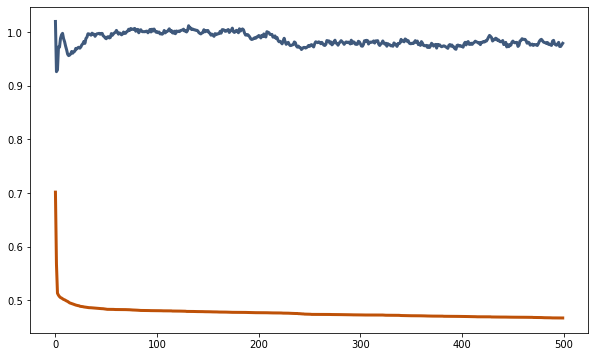

In [13]:
plt.figure(figsize=(10,6))
plt.plot(range(0,len(exp_genetic.average_loss_list)),exp_genetic.average_loss_list, color="#3F597C", linewidth=3)
plt.plot(range(0,len(exp_genetic.average_top_loss_list)),exp_genetic.average_top_loss_list, color="#BE5108",linewidth=3)
#plt.savefig("images/ga_avg_loss.png")

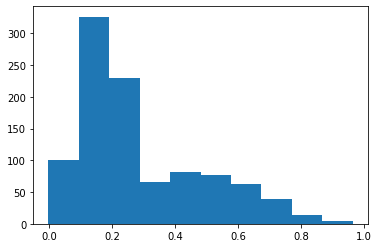

In [9]:
plt.hist(exp_genetic.final_cfs_df["income"])
#plt.xlim(0.0, 1.0)
plt.show()

In [10]:
#exp_genetic.final_cfs_df.to_csv("LCA/R/csv/exp_genetic_test2_1000.csv", index=False)